In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
# plt.style.use('ggplot')


df = pd.read_csv(r'data/rawData_Feb11.csv').set_index('Date')
# set date as index
# since we only care about trading until the end of 2021, we drop all data after that
df = df.loc[:'2022-01-01']
display(df)

,RAY,VIX,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,VXUS,EEM
Date,,,,,,,,,,,,
1990-01-02,200.241,17.24,NaN,0.11,NaN,NaN,NaN,NaN,NaN,1.2146,NaN,NaN
1990-01-03,200.116,18.19,NaN,0.10,NaN,NaN,NaN,NaN,NaN,1.2096,NaN,NaN
1990-01-04,198.646,19.22,NaN,0.14,NaN,NaN,NaN,NaN,NaN,1.2287,NaN,NaN
1990-01-05,196.850,20.11,NaN,0.20,NaN,NaN,NaN,NaN,NaN,1.2358,NaN,NaN
1990-01-08,197.525,20.26,NaN,0.23,NaN,NaN,NaN,NaN,NaN,1.2452,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2803.742,17.68,403.48,1.42,75.57,446.50,1808.1,23.0676,114.00,1.1328,63.70,48.94
2021-12-28,2798.353,17.54,401.61,1.43,75.98,442.00,1810.2,23.0200,114.42,1.1310,63.63,48.78
2021-12-29,2801.873,16.95,401.55,1.50,76.56,440.20,1805.1,22.8331,115.19,1.1349,63.57,48.56


In [2]:
def first_valid_table(dataframe):
    """
    get first valid information for the given data
    :param dataframe: pd.DataFrame;
    :return:
    """
    first_valid = pd.DataFrame(columns=['First Valid Date', 'Total N/A', 'N/A Since First valid'])
    # first obs date
    first_valid['First Valid Date'] = dataframe.apply(lambda x: x.first_valid_index())
    # Total NA
    first_valid['Total N/A'] = dataframe.apply(lambda x: x.isnull().sum(axis=0))
    # NA since first_date
    first_valid['N/A Since First valid'] = dataframe.apply(lambda x: x.loc[x.first_valid_index():].isnull().sum(axis=0))

    first_valid.sort_values("First Valid Date", inplace=True)
    return first_valid

display(first_valid_table(df))

,First Valid Date,Total N/A,N/A Since First valid
RAY,1990-01-02,277,277
VIX,1990-01-02,288,288
T10Y3M,1990-01-02,0,0
EURtoUSD,1990-01-02,71,71
CL1,1990-01-11,311,304
HG1,1990-01-11,310,303
GC1,1990-01-11,311,304
XAG,1990-01-11,54,47
QQQ,1999-03-10,2606,210
EEM,2003-07-01,3689,169


In [3]:
# forward fill
df.ffill(inplace=True)
# check again after ffill
display(first_valid_table(df))

,First Valid Date,Total N/A,N/A Since First valid
RAY,1990-01-02,0,0
VIX,1990-01-02,0,0
T10Y3M,1990-01-02,0,0
EURtoUSD,1990-01-02,0,0
CL1,1990-01-11,7,0
HG1,1990-01-11,7,0
GC1,1990-01-11,7,0
XAG,1990-01-11,7,0
QQQ,1999-03-10,2396,0
EEM,2003-07-01,3520,0


Since stationary process involve partial differentiation, which is a ML model to learn the best degree to fit the data, I have to separate train and test set. I'll manually walk thru a train set up to 12/31/2017 to create content and graphs for the paper. Then I will create a model class with train and fit method to automate this process

In [4]:
# split training set
df = df.loc[:'2018-01-01']
display(df)

,RAY,VIX,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,VXUS,EEM
Date,,,,,,,,,,,,
1990-01-02,200.241,17.24,NaN,0.11,NaN,NaN,NaN,NaN,NaN,1.2146,NaN,NaN
1990-01-03,200.116,18.19,NaN,0.10,NaN,NaN,NaN,NaN,NaN,1.2096,NaN,NaN
1990-01-04,198.646,19.22,NaN,0.14,NaN,NaN,NaN,NaN,NaN,1.2287,NaN,NaN
1990-01-05,196.850,20.11,NaN,0.20,NaN,NaN,NaN,NaN,NaN,1.2358,NaN,NaN
1990-01-08,197.525,20.26,NaN,0.23,NaN,NaN,NaN,NaN,NaN,1.2452,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,1586.998,10.25,156.52,1.00,59.97,325.60,1284.1,16.5522,82.24,1.1858,56.50,46.46
2017-12-27,1588.156,10.47,156.54,0.98,59.64,325.70,1287.0,16.6917,82.51,1.1888,56.60,46.58
2017-12-28,1591.449,10.18,156.73,1.04,59.84,330.85,1297.2,16.8630,82.95,1.1943,56.70,46.90


In [5]:
#Fixed-width Fractional Difference (FFD)
#article source: https://www.kaggle.com/elvisesp/time-series-analysis-using-fractional-differencing
#code source: https://gist.github.com/skuttruf/fb82807ab0400fba51c344313eb43466
import statsmodels
from statsmodels.tsa.stattools import adfuller

#run adf test for initial time series from first valid
def adf_table(series):
    """
    run adf test for initial time series from first valid
    Fixed-width Fractional Difference (FFD)
    article source: https://www.kaggle.com/elvisesp/time-series-analysis-using-fractional-differencing
    code source: https://gist.github.com/skuttruf/fb82807ab0400fba51c344313eb43466
    :param series: pd.DataFrame;
    :return:
    """
    # adf = pd.DataFrame(columns=['ADF Statistic', 'ADF p-value', 'Reject H0 at 5%?'])
    # first obs date
    series = series.loc[series.first_valid_index():]
    adf_test = adfuller(series)
    reject = "Yes" if adf_test[1] < 0.05 else "No"
    return round(adf_test[0], 4), round(adf_test[1], 4), reject

df = df.drop(columns=['VXUS'])
diff_info_pre = df.apply(lambda x: adf_table(x))
diff_info_pre.index = ['ADF Statistic', 'ADF p-value', 'Reject at 5%?']
diff_info_pre = diff_info_pre.T
display(diff_info_pre)

,ADF Statistic,ADF p-value,Reject at 5%?
RAY,1.0773,0.995,No
VIX,-5.1378,0.0,Yes
QQQ,0.8785,0.9928,No
T10Y3M,-2.2222,0.1983,No
CL1,-1.6043,0.4814,No
HG1,-1.2794,0.6386,No
GC1,-0.4028,0.9096,No
XAG,-1.4101,0.5774,No
VNQ,-1.6614,0.4511,No
EURtoUSD,-2.1399,0.2288,No


UPDATE VERSION:
At first I tried to incorporate log transformation into the pipeline. However, log transformation has weakness (which we should include in our paper). There is a complication of removing already stationary series and series that may have negative values (now or in the future). Take oil price, if our train set only include before 2018, we won't observe negative oil price. That will cause bugs in our pipeline in 2020. Furthermore, I tested both approach and see that the memory reserved (measured by the correlation of the final series to the original series) are very similar for both approach, 0.8981 for no-log version and 0.8645 for log version applied on GC1. Thus, log-transformation is unlikely to add value to our pipeline and very complex to implement.
PREVIOUS VERSION:
Since partial differentiation is expensive, we use log transformation to partly stationarize the time series first
for better convergence in Partial diff. 
We note that the problem with log transform is it does not take care of negative value.
T10Y3M is the spread between 10Y and 3M bond yields so it can be negative.
With hindsight, CL1 is crude oil and in 2020 we had the negative price for the first time in history.
using log transform will lose information. So we won't transform those with negative value.
Since VIX is already unit-root stationary, we do not need to further transform it. We create new log dataframe of other vars.

In [6]:
# #log transform our dataset except for VIX, T10Y3M. Note here we still log transform CL1 because in our trainset
# #there is no negative CL1, we have to pay attention in the fit method of the stationary class
# df_log = np.log(df.drop(['VIX','T10Y3M'], axis=1).copy(deep=True))
# display(df_log)

In [7]:
# #test if log transform caused new missing value
# display(first_valid_table(df_log))
# #all good
# #test adf for log dataframe
# display(adf_table(df_log))

OLD: After the log transformation, we observe the ADF Statistic of our variables. Most of the t-stats improved to nearer satisfied the critical value for rejecting the null hypothesis. Note that log(EEM) is now stationary.

In [8]:
#code for partial differentiation
#get the weights of past data for each data point
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

    
def cutoff_find(order,cutoff,start_lags): #order is our dearest d, cutoff is 1e-5 for us, 
    #and start lags is an initial amount of lags in which the loop will start, 
    #this can be set to high values in order to speed up the algo
    val=np.inf
    lags=start_lags
    while abs(val)>cutoff:
        w=getWeights(order, lags)
        val=w[len(w)-1]
        lags+=1
    return lags


def ts_differencing_tau(series, order, tau):
    # return the time series resulting from (fractional) differencing
    lag_cutoff=(cutoff_find(order,tau,1)) #finding lag cutoff with tau
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [9]:
# Other implementation, I find the two very much similar and give the very similar results
# but the above implementation is faster in computing
# source: https://medium.com/swlh/fractionally-differentiated-features-9c1947ed2b55
# def getWeights_FFD(d=0.1, thres=1e-5):
#     w,k=[1.],1
#     while True:
#         w_=-w[-1]/k*(d-k+1)
#         if abs(w_)<thres:break
#         w.append(w_)
#         k+=1
#     return np.array(w[::-1]).reshape(-1,1)

# def frac_diff_FFD(col, d=0.1, thres=1e-4):
#     #3) Apply weights to values
#     w=getWeights_FFD(d,thres)
#     width=len(w)-1
#     df = pd.Series(dtype='float64')
#     #widow size can't be larger than the size of data
#     if width >= col.shape[0]:raise Exception("width is oversize")
        
#     for i in range(width, col.shape[0]):
#         i_0_index, i_1_index = col.index[i-width], col.index[i]
#         data = np.dot(w.T, col.loc[i_0_index:i_1_index])[0]
        
#         df[i_1_index] = data
                   
#     return df

# frac_diff_FFD(df['RAY'])
# one_time = 0
# possible_d=np.divide(range(1,100),100)
# for i in range(len(possible_d)):
#     print('processing d',possible_d[i])
#     pd_series= frac_diff_FFD(df['RAY'],possible_d[i])
#     ad_pvalue = adfuller(pd_series)[1]
#     if (one_time == 0) and ad_pvalue <= 0.05:
#         one_time = 1
#         best_d = possible_d[i]
#         best_series = pd_series
#     adf_stat_holder[i]=ad_pvalue

    
# #graphing
# print('best degree:',best_d)
# plt.plot(possible_d,adf_stat_holder)
# plt.title('ADF P-value by differencing order in RAY series')
# plt.axhline(y=0.05,color='r')
# ser= frac_diff_FFD(df['RAY'],0.48)
# df['RAY'].corr(ser)

In [10]:
# OLD
# #create pre part-diff dataframe
# #drop EEM from df_log and join with df[['T10Y3M','CL1']]
# df_prepd=pd.concat([df_log.drop('EEM',axis=1), df[['T10Y3M']]], axis=1)
# display(df_prepd)
# display(df_log.drop('EEM',axis=1))
# display(df[['T10Y3M']])

In [11]:
# OLD
# #check if joining cause any missing value, it should not
# display(first_valid_table(df_prepd))
# #it look good
# display(adf_table(df_prepd))

In [12]:
possible_d = np.divide(range(1,100),100)
tau = 1e-4
best_d = 0
# df_postpd=df_prepd.copy(deep=True)
adf_stat_holder = [None]*len(possible_d)

In [13]:
# OLD
# #Here we pick the variable with highest p-value for visualization, which is GC1 in this case
# #run pd on GC1 for graphing
# one_time=0
# #first valid index for GC1
# GC1_first = df_prepd['GC1'].first_valid_index()
# for i in range(len(possible_d)):
#     pd_series=ts_differencing_tau(df_prepd[df_prepd.index>=GC1_first]['GC1'],possible_d[i],tau)
#     ad_pvalue = adfuller(pd_series)[1]
#     if (one_time == 0) and ad_pvalue <= 0.05:
#         one_time = 1
#         best_d = possible_d[i]
#         best_series = pd_series
#     adf_stat_holder[i]=ad_pvalue

In [14]:
#Here we pick the variable with highest p-value for visualization, which is RAY in this case
#run pd on RAY for graphing
one_time = 0
#first valid index
first_valid = df['RAY'].first_valid_index()
for i in range(len(possible_d)):
    pd_series = ts_differencing_tau(df[df.index>=first_valid]['RAY'],possible_d[i],tau)
    ad_pvalue = adfuller(pd_series)[1]
    if (one_time == 0) and ad_pvalue <= 0.05:
        one_time = 1
        best_d = possible_d[i]
        best_series = pd_series
    adf_stat_holder[i] = ad_pvalue

best degree: 0.48


Text(0.5, 0, 'Differencing Order (d)')

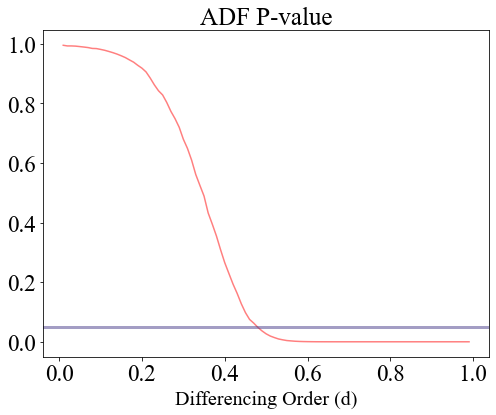

In [15]:
# graphing
figsize = 8, 6
figure, ax = plt.subplots(figsize=figsize)

font1 = {'family': 'Times New Roman',
'weight': 'normal',
'size': 20,
}

font2 = {'family': 'Times New Roman',
'weight': 'normal',
'size': 25,
}

print('best degree:', best_d)
plt.plot(possible_d, adf_stat_holder, color='r', alpha=0.5)
plt.axhline(y=0.05, color='darkslateblue', linewidth=3.0, alpha=0.5)

# legend = plt.legend(prop=font1)


plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.title('ADF P-value', font2)  # by Difference Order in RAY Series'
plt.xlabel("Differencing Order (d)", font1)
# plt.ylabel("ADF P-value", font1)


In [16]:
best_series

Date
1990-11-01     6.882541
1990-11-02     8.922423
1990-11-05     9.031127
1990-11-06     6.734745
1990-11-07     4.234309
                ...    
2017-12-26    79.873605
2017-12-27    81.156415
2017-12-28    83.635936
2017-12-29    72.946060
2018-01-01    76.348697
Name: RAY, Length: 7088, dtype: float64

In [17]:
df[df.index >= df['RAY'].first_valid_index()]['RAY']
#Note that here partial diff makes us lose some data points
#but we need to pay attention when updating our dataframe

Date
1990-01-02     200.241
1990-01-03     200.116
1990-01-04     198.646
1990-01-05     196.850
1990-01-08     197.525
                ...   
2017-12-26    1586.998
2017-12-27    1588.156
2017-12-28    1591.449
2017-12-29    1582.770
2018-01-01    1582.770
Name: RAY, Length: 7305, dtype: float64

In [18]:
df[df.index>=df['RAY'].first_valid_index()]['RAY'].corr(best_series)

0.8609217791180349

In [19]:
pd.concat([df,pd.DataFrame(best_series).rename(columns={'RAY': 'RAY'+'_pd'})], axis=1)

,RAY,VIX,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,EEM,RAY_pd
Date,,,,,,,,,,,,
1990-01-02,200.241,17.24,NaN,0.11,NaN,NaN,NaN,NaN,NaN,1.2146,NaN,NaN
1990-01-03,200.116,18.19,NaN,0.10,NaN,NaN,NaN,NaN,NaN,1.2096,NaN,NaN
1990-01-04,198.646,19.22,NaN,0.14,NaN,NaN,NaN,NaN,NaN,1.2287,NaN,NaN
1990-01-05,196.850,20.11,NaN,0.20,NaN,NaN,NaN,NaN,NaN,1.2358,NaN,NaN
1990-01-08,197.525,20.26,NaN,0.23,NaN,NaN,NaN,NaN,NaN,1.2452,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,1586.998,10.25,156.52,1.00,59.97,325.60,1284.1,16.5522,82.24,1.1858,46.46,79.873605
2017-12-27,1588.156,10.47,156.54,0.98,59.64,325.70,1287.0,16.6917,82.51,1.1888,46.58,81.156415
2017-12-28,1591.449,10.18,156.73,1.04,59.84,330.85,1297.2,16.8630,82.95,1.1943,46.90,83.635936


In [20]:
#create normalized graph of 2 series
def normalize(series):
    series = (series - min(series))/(max(series)-min(series))
    return series

norm1 = normalize(best_series)
norm2 = normalize(df.loc[norm1.first_valid_index():, 'RAY'])

In [21]:
len(norm1)

7088

In [22]:
len(norm2)

7088

Text(0.5, 0, 'Time')

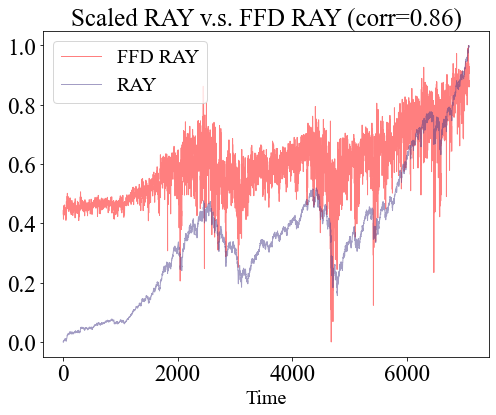

In [31]:
norm1.name = 'FFD RAY'
x = norm1.reset_index().index

figsize = 8, 6
figure, ax = plt.subplots(figsize=figsize)
 
A, = plt.plot(x, norm1,'r',label='FFD RAY', linewidth=1.0, alpha=0.5)
B, = plt.plot(x, norm2,'darkslateblue',label='RAY', linewidth=1.0, alpha=0.5)
 
legend = plt.legend(handles=[A, B], prop=font1)
 
plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.title('Scaled RAY v.s. FFD RAY (corr=0.86)', font2)
plt.xlabel('Time', font1)
 

See how the technique stationarize our series while reserve the trend

In [24]:
#train for all columns
best_series = []
best_d = []
name = []
adf_stat_holder = []
#remove VIX from training since it is already stationary
for col in df.drop(columns=['VIX']).columns:
    print('processing column ',col)
    first_valid = df[col].first_valid_index()
    name.append(col)
    for i in range(len(possible_d)):
        pd_series=ts_differencing_tau(df[df.index>=first_valid][col],possible_d[i],tau)
        ad_pvalue = adfuller(pd_series)[1]
        if ad_pvalue <= 0.05:
            print('d',possible_d[i])
            best_d.append(possible_d[i])
            best_series.append(pd_series)
            adf_stat_holder.append(ad_pvalue)
            break


processing column  RAY
d 0.48
processing column  QQQ
d 0.44
processing column  T10Y3M
d 0.11
processing column  CL1
d 0.18
processing column  HG1
d 0.27
processing column  GC1
d 0.44
processing column  XAG
d 0.26
processing column  VNQ
d 0.2
processing column  EURtoUSD
d 0.1
processing column  EEM
d 0.05


In [25]:
#create dataframe to show training info
pd_train_info = pd.DataFrame(columns=[None,'differentiation degree (d)','ADF-test p-value','Reject H0 at 5%?'])
reject = 'No'
for i in range(len(name)):
    if adf_stat_holder[i] <= 0.05:
        reject='Yes'
    pd_train_info.loc[i]= [name[i],best_d[i],round(adf_stat_holder[i],3),reject]
pd_train_info.set_index(None,inplace=True)
display(pd_train_info)

,differentiation degree (d),ADF-test p-value,Reject H0 at 5%?
RAY,0.48,0.048,Yes
QQQ,0.44,0.047,Yes
T10Y3M,0.11,0.046,Yes
CL1,0.18,0.045,Yes
HG1,0.27,0.041,Yes
GC1,0.44,0.045,Yes
XAG,0.26,0.046,Yes
VNQ,0.20,0.047,Yes
EURtoUSD,0.10,0.038,Yes
EEM,0.05,0.048,Yes


In [26]:
#correlation with original series table
corr_tab = pd.DataFrame(columns=[None,'ffd correlation','d=1 correlation'])
for i in range(len(name)):
    corr = df[name[i]].corr(best_series[i])
    corr2 = df[name[i]].diff().corr(df[name[i]])
    corr_tab.loc[i]= [name[i],round(corr,4),round(corr2,4)]
corr_tab.set_index(None,inplace=True)
display(corr_tab)    

,ffd correlation,d=1 correlation
RAY,0.8609,0.0290
QQQ,0.8538,0.0424
T10Y3M,0.9474,0.2694
CL1,0.9647,0.0187
HG1,0.9282,0.0190
GC1,0.8981,0.0149
XAG,0.9331,0.0171
VNQ,0.9400,0.0332
EURtoUSD,0.9880,0.0251
EEM,0.9948,0.0254


In [27]:
#integrate series
df_ffd=pd.DataFrame(index=df.index)
for i in best_series:
    df_ffd = pd.concat([df_ffd,i],axis=1)
df_ffd = pd.concat([df_ffd,df['VIX']],axis=1)

In [28]:
display(df_ffd)
display(first_valid_table(df_ffd))

,RAY,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,EEM,VIX
Date,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.24
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.19
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.22
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.11
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.26
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,79.873605,9.216266,0.504588,20.102750,64.255140,83.243787,2.832413,19.836294,0.603736,33.946309,10.25
2017-12-27,81.156415,9.576155,0.429218,19.451854,62.712927,81.567041,2.905307,20.089117,0.606686,34.059226,10.47
2017-12-28,83.635936,9.827679,0.476714,19.557389,67.016739,88.925772,3.014117,20.494257,0.611797,34.366958,10.18


,First Valid Date,Total N/A,N/A Since First valid
VIX,1990-01-02,0,0
RAY,1990-11-01,217,0
GC1,1990-12-26,256,0
HG1,1991-08-28,431,0
XAG,1991-09-13,443,0
EURtoUSD,1991-12-10,505,0
T10Y3M,1991-12-26,517,0
CL1,1992-01-02,522,0
QQQ,2000-02-22,2645,0
EEM,2004-11-22,3884,0


In [29]:
display(first_valid_table(df))

,First Valid Date,Total N/A,N/A Since First valid
RAY,1990-01-02,0,0
VIX,1990-01-02,0,0
T10Y3M,1990-01-02,0,0
EURtoUSD,1990-01-02,0,0
CL1,1990-01-11,7,0
HG1,1990-01-11,7,0
GC1,1990-01-11,7,0
XAG,1990-01-11,7,0
QQQ,1999-03-10,2396,0
EEM,2003-07-01,3520,0


## SUMMERY:
After running ffd, we conclude that it does generate stationary data with preserved long-time memory.This algo created some missing value at the front. The reason is that it uses a fixed-width sliding window to weight the data point. Thus, we don't really lose observations since their information is contained as weights for the new variable. Next step is to use these degree to differentiate our test data, until we retrain our model.
I'll write a class with 2 functions fit and transform for this purpose later.


In [30]:
# export to csv
df_ffd.to_csv(root+'/stationary_ffd_fitted_trainset_01012018')

NameError: name 'root' is not defined